In [4]:
import pickle
import numpy as np
import pandas as pd

from random import shuffle
from konlpy.tag import Mecab
from collections import Counter
from scipy.sparse import dok_matrix
from sklearn.decomposition import NMF
from sklearn.preprocessing import normalize

In [5]:
data_daelim = pd.read_csv('./data/GCPKoreanMuseumData/#daelim/daelim_distinct_text_cleansing.csv')[['name', 'text']]
data_leeum = pd.read_csv('./data/GCPKoreanMuseumData/#leeum/leeum_distinct_text_cleansing.csv')[['name', 'text']]
data_mmcaseoul = pd.read_csv('./data/GCPKoreanMuseumData/#mmcaseoul/mmcaseoul_distinct_text_cleansing.csv')[['name', 'text']]
data_museumkorea = pd.read_csv('./data/GCPKoreanMuseumData/#museumkorea/museumkorea_distinct_text_cleansing.csv')[['name', 'text']]
data_nfmkorea = pd.read_csv('./data/GCPKoreanMuseumData/#nfmkorea/nfmkorea_distinct_text_cleansing.csv')[['name', 'text']]

In [6]:
data_museumkorea

,name,text
0,2019-10-05 20.44.13 2147951996391675319_국립중앙박물...,북청사자놀음 국립중앙박물관 북청사자놀음 국립중앙박물관
1,2019-10-05 21.07.58 2147963949025510093_국립중앙박물...,통일신라 몬딱 내 스톼일 자랑스러운 나의 나라 국립중앙박물관 선사시대만 두시간
2,2019-10-05 21.08.18 2147964122988469336_국립중앙박물...,사진일기 국립중앙박물관 올라가는 길근래에 직접찍은 사진을 올리기가 머뭇거리고 있었다...
3,2019-10-05 21.23.06 2147971566149981269_국립중앙박물...,우리가 역사를 잊지말아야 하는 이유수백만가지가 되는 우리모두의 이유입니다 가슴 속 ...
4,2019-10-05 21.28.01 2147974037257993392_국립중앙박물...,토요일 신나는토요일 나들이 세아들과함께 가족나들이 국립중앙박물관 한글박물관 사진에는...
...,...,...
2320,2019-10-30 11.56.39 2165805855627230915_국립중앙박물...,다음 폰은 갤럭시로 좋아요반사 팔로우 좋아요 팔로우환영 갤럭시노트 국립중앙박물관
2321,2019-10-30 12.17.35 2165816392558277996_국립중앙박물...,생전 처음으로 실제 불쇼를 볼 거라고 생각도 못하고 박물관 간 날 너무 전통공연만 ...
2322,2019-10-30 12.26.05 2165820677559827366_국립중앙박물...,조선의 서커스를 주창하면서 남사당에 줄타기에 이것저것 한번에 볼 수 있어서 좋았는데...
2323,2019-11-02 13.45.36 2168035019855374361_국립중앙박물...,오랜만에 박물관나들이 프로그램도 알차고 즐겁게 잘 하고옴 국립중앙박물관 통통이네주말...


In [21]:
pd.read_csv('./Komoran_stopwords.txt', sep='\t', names=['words',  'tag', 'score'], header=None)

,words,tag,score
0,이,VCP,0.018280
1,있,VA,0.011699
2,하,VV,0.009774
3,것,NNB,0.009733
4,들,XSN,0.006898
...,...,...,...
95,원,NNB,0.000492
96,잘,MAG,0.000491
97,통하,VV,0.000487
98,소리,NNG,0.000486


In [7]:
total_text_list = data_daelim['text'].tolist()
total_text_list.extend(data_leeum['text'].tolist())
total_text_list.extend(data_mmcaseoul['text'].tolist())
total_text_list.extend(data_museumkorea['text'].tolist())
total_text_list.extend(data_nfmkorea['text'].tolist())

total_text_num = len(total_text_list)

In [ ]:
tags = set(['Noun', 'Verb', 'Adjective'])
spamWords = set([
    '하다', '되다', '이다', '전재', '배포', '무단', '기사', '금지', '사진', '보기', '뉴스', '있다',
    '돼다', '앵커', '위해', '라며', '그렇다', '보다', '되어다', '기자', '하는', '이런', '그런', '하는', '이상'
])

In [ ]:
def tdm_make(museum, tags, stopwords):
    if museum  == 'daelim':
        dat_ = data_daelim['text']
    elif museum  == 'leeum':
        dat_ = data_leeum['text']
    elif museum  == 'mmcaseoul':
        dat_ = data_mmcaseoul['text']
    elif museum  == 'museumkorea':
        dat_ = data_museumkorea['text']
    elif museum  == 'nfmkorea':
        dat_ = data_nfmkorea['text']
    elif museum == 'total':
        dat_ = data_daelim['text'].tolist()
        dat_.extend(data_leeum['text'].tolist())
        dat_.extend(data_mmcaseoul['text'].tolist())
        dat_.extend(data_museumkorea['text'].tolist())
        dat_.extend(data_nfmkorea['text'].tolist())
        dat_ = pd.DataFrame({'text': dat_})['text']

    mecab = Mecab()

    word_count = Counter()

    for article in text_list:
        words = list()
        pos = mecab.pos(article, norm=True, stem=True)
        if not stopwords == None:
            word_count.update([word for word, tag in pos if tag in tags and len(word) >1 and word not in stopwords])
        else:
            word_count.update([word for word, tag in pos if tag in tags and len(word) >1])            

    wordsList = list()
    raw_text = list()
    index2voca = set()
    for article in text_list:

        words = []
        pos = twitter.pos(article, norm=True, stem=True)
        words = [word for word, tag in pos if word_count[word] >= 10]
        if len(words) >= 10:
            index2voca.update(words)
            wordsList.append(words)
            raw_text.append(article)

    index2voca = list(index2voca)
    voca2index = {w: i for i, w in enumerate(index2voca)}

    tdm = dok_matrix((len(wordsList), len(index2voca)), dtype=np.float32)

    for i, words in enumerate(wordsList):
        for word in words:
            tdm[i, voca2index[word]] += 1

    tdm = tdm.tocsr()
    tdm = normalize(tdm)

    with open(f'./data/preprocessed_{}.pkl', 'wb') as f:
        pickle.dump({'index2voca': index2voca, 'voca2index': voca2index, 'wordsList': wordsList, 'tdm': tdm, 'raw_text': raw_text}, f)

In [5]:
# NMF
K = 10
nmf = NMF(n_components=K, max_iter=1000, alpha=0.1)
W = nmf.fit_transform(preprocessed_data['tdm'])
H = nmf.components_

# 각 토픽별 키워드 출력
for k in range(K):
    print(f"{k}th topic")
    for index in H[k].argsort()[::-1][:20]:
        print(preprocessed_data['index2voca'][index], end=" ")
    print("\n")

0th topic
박물관 민속 국립 경복궁 어린이 나들이 추억 거리 삼청동 체험 아들 가다 엄마 오다 아이 주말 수업 많다 교육 고양이 

1th topic
미술관 국립 현대 삼청동 박서보 전시회 미술 작가 모르다 지치다 김순 광장 수행자 게으르다 나들이 구름 아스 보틀 블루 보전 

2th topic
하이 대림 미술관 사연 가지 일곱 숨기다 전시회 아욘 문화생활 주말 일상 디자인 나들이 상상 데이트 가다 지엄 힐링 즐겁다 

3th topic
그램 스타 일상 일리 육아 소통 아들 주말 맞팔 여행 셀카 아기 선팔 엄마 전시회 아스타 셀피 먹다 패션 데이트 

4th topic
박물관 중앙 국립 에트루리아 세종 뮤지컬 로마 한글 가을 이전 한글날 우리 용산 어린이 가다 장용 주말 오늘 전시회 오다 

5th topic
좋다 날씨 맞팔 일상 가을 선팔 오늘 반사 많다 시간 사람 소통 팔로우 오다 기분 같다 없다 넘다 가다 하늘 

6th topic
전시 작품 작가 에트루리아 관람 로마 생각 같다 미술 이전 우리 전시회 가다 않다 들다 없다 많다 보고 시간 오다 

7th topic
서울 여행 나들이 경복궁 한국 투어 구경 대한민국 광화문 일상 북촌 인사동 가족 가보다 가을 주말 출사 스냅 이태원 관광 

8th topic
리움 미술관 삼성 이태원 미술 한남동 작품 가다 한국 아니다 하늘 대림 예술 카푸 건축 주말 여행 최정화 일상 지엄 

9th topic
맛집 경복궁 데이트 대림 미술관 카페 광화문 와인 파스타 오늘 먹다 나들이 삼청동 경복궁역 회식 종로 젤라또 가다 단체 쿠퍼 



In [6]:
from krwordrank.word import KRWordRank

wordrank_extractor = KRWordRank(
    min_count = 5, # 단어의 최소 출현 빈도수 (그래프 생성 시)
    max_length = 10, # 단어의 최대 길이
    verbose = True
    )

beta = 0.85    # PageRank의 decaying factor beta
max_iter = 10

In [35]:
keywords, rank, graph = wordrank_extractor.extract(preprocessed_data['raw_text'], beta, max_iter)

keyword_dict = dict()

for word, r in sorted(keywords.items(), key=lambda x:x[1], reverse=True)[:300]:
#     print('%8s:\t%.4f' % (word, r))
    keyword_dict[word] = r

scan vocabs ... 
num vocabs = 21686
done = 10


In [19]:
from wordcloud import WordCloud

texts = ['이것 은 예문 입니다', '여러분 의 문장을 넣 으세요']
keywords = {'이것':5, '예문':3, '단어':5, '빈도수':3}

wordcloud = WordCloud()
wordcloud = wordcloud.generate_from_text(texts[0])
wordcloud = wordcloud.generate_from_frequencies(keyword_dict)

In [20]:
wordcloud = WordCloud(
    width = 800,
    height = 800
)

wordcloud = wordcloud.generate_from_frequencies(keywords)

In [10]:
font_path = '/usr/share/fonts/truetype/nanum/NanumGothic.ttf'

In [21]:
from wordcloud import WordCloud

wordcloud = WordCloud(
    font_path = font_path,
    width = 800,
    height = 800
)
wordcloud = wordcloud.generate_from_frequencies(keyword_dict)

In [22]:
def __array__(self):
    """Convert to numpy array.
    Returns
    -------
    image : nd-array size (width, height, 3)
        Word cloud image as numpy matrix.
    """
    return self.to_array()

def to_array(self):
    """Convert to numpy array.
    Returns
    -------
    image : nd-array size (width, height, 3)
        Word cloud image as numpy matrix.
    """
    return np.array(self.to_image())

In [23]:
array = wordcloud.to_array()
print(type(array)) # numpy.ndarray
print(array.shape) # (800, 800, 3)

<class 'numpy.ndarray'>
(800, 800, 3)


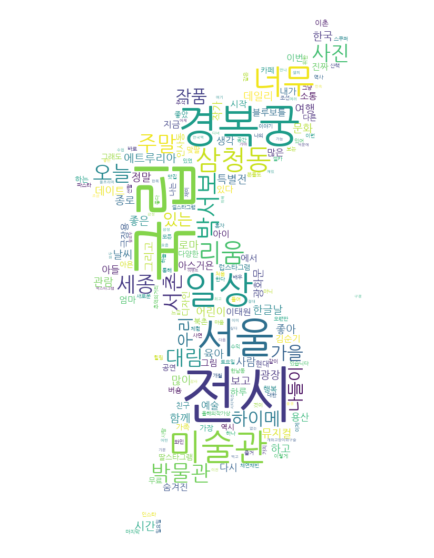

In [41]:
%matplotlib inline
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np

mask = np.array(Image.open('./data/korea.jpg'))

wordcloud = WordCloud(
    font_path = font_path,
    mask=mask,
    width = 800,
    height = 800,
    background_color="white",
#     width=mask.shape[1],
#     height=mask.shape[0]
)

wordcloud = wordcloud.generate_from_frequencies(keyword_dict)
plt.figure(figsize=(10, 10))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()